In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import efficientnet.tfkeras as efn

from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


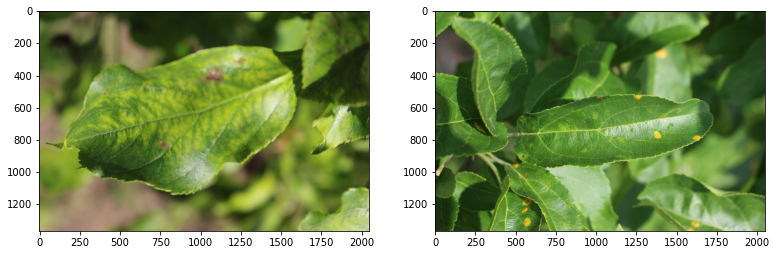

(1365, 2048, 3)


In [2]:
def read_image(file):
    raw = tf.io.read_file(file)
    image = tf.io.decode_jpeg(raw)
    image = tf.cast(image, tf.float32) / 255.0
    return image


train_image = read_image('./images/Train_0.jpg')
test_image = read_image('./images/Test_0.jpg')

plt.figure(figsize=(13, 6))
plt.subplot(1, 2, 1)
plt.imshow(train_image)
plt.subplot(1, 2, 2)
plt.imshow(test_image)
plt.show()

print(train_image.shape)

In [3]:
INPUT_SIZE = (512, 512)
SCALE_UP = 1.3


def random_flip(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image


def random_crop(image):
    target_size = [int(INPUT_SIZE[0] * SCALE_UP), INPUT_SIZE[0]]
    image = tf.image.resize(image, [int(target_size[0] * SCALE_UP), int(target_size[1] * SCALE_UP)],
                            tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.image.random_crop(image, [target_size[0], target_size[1], 3])
    return image


@tf.function
def random_rotate(image):
    p = tf.random.uniform((), 0, 1.0)
    if p < 0.25:
        image = tf.image.rot90(image, 1)
    elif p < 0.5:
        image = tf.image.rot90(image, 2)
    elif p < 0.75:
        image = tf.image.rot90(image, 3)
    return image


def random_jitter(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_contrast(image, 0.5, 1.6)
    image = tf.image.random_saturation(image, 0.8, 1.3)
    image = tf.image.random_brightness(image, 0.03)
    image = tf.clip_by_value(image, 0, 1.0)
    return image


@tf.function
def random_process(image):
    image = random_flip(image)
    # if tf.random.uniform((), 0, 1.0) > 0.1:
    #     image = random_crop(image)
    image = tf.image.resize(image, [INPUT_SIZE[0], INPUT_SIZE[0]])
    # image = random_rotate(image)
    image = random_jitter(image)
    return image

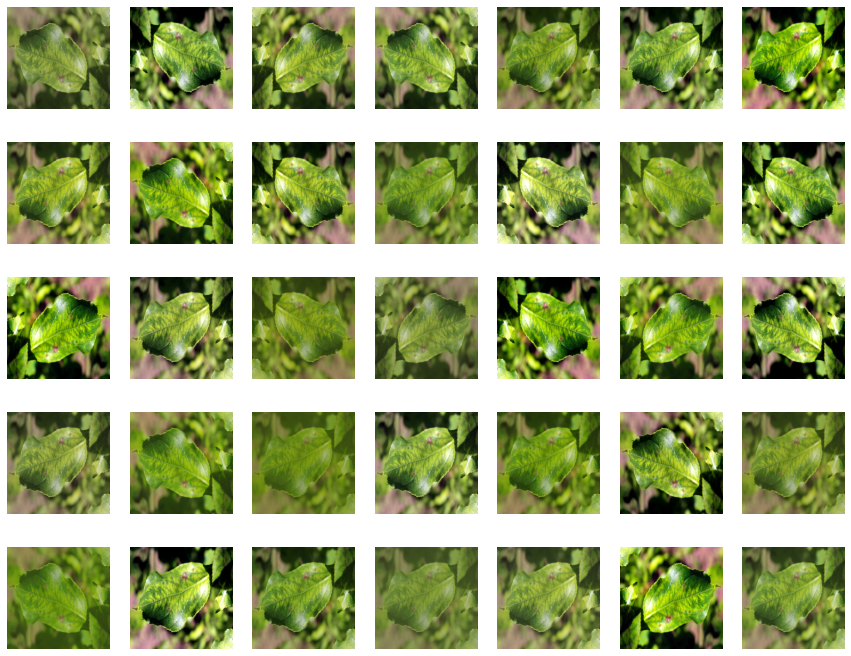

In [4]:
def show_random_processed(func):
    plt.figure(figsize=(15, 12))
    for n in range(35):
        test_image = func(train_image)
        plt.subplot(5, 7, n+1)
        plt.imshow(test_image)
        plt.axis('off')
    plt.show()


show_random_processed(random_process)

In [5]:
def get_train_valid_split(csv, train_percent=0.85):
    csv = pd.read_csv(csv)
    images = []
    labels = []
    for row in csv.values:
        images.append('./images/' + row[0] + '.jpg')
        labels.append(row[1:])
    assert len(images) == len(labels)
    
    pair = [(images[i], labels[i]) for i in range(len(images))]
    np.random.shuffle(pair)
    
    train_size = int(len(images) * train_percent)
    train_images = [p[0] for p in pair[:train_size]]
    train_labels = [p[1] for p in pair[:train_size]]
    valid_images = [p[0] for p in pair[train_size:]]
    valid_labels = [p[1] for p in pair[train_size:]]
    
    print('train size: ', len(train_images))
    print('valid size: ', len(valid_images))
    
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    valid_ds = tf.data.Dataset.from_tensor_slices((valid_images, valid_labels))
    return train_ds, valid_ds


def train_pipeline(image_path, label):
    image = read_image(image_path)
    image = random_process(image)
    return image, label


def valid_pipeline(image_path, label):
    image = read_image(image_path)
    image = tf.image.resize(image, INPUT_SIZE)
    return image, label

In [12]:
def submission(output_name):
    csv = pd.read_csv('./sample_submission.csv')
    for i in range(len(csv)):
        row = csv.iloc[i]
        image = read_image('./images/' + row[0] + '.jpg')
        image = tf.image.resize(image, INPUT_SIZE)
        image = image[tf.newaxis, ...]
        results = model.predict(image)
        csv.iloc[i, 1:] = results[0]
        print('\rprocessed: %d/%d' % (i+1, len(csv)), end='')
    print()
    csv.to_csv(output_name, index=False)
    print(csv.head())

# EfficientNetB6

In [ ]:
BATCH_SIZE = 2
train_ds, valid_ds = get_train_valid_split('./train.csv')

train_ds = train_ds.map(train_pipeline)
valid_ds = valid_ds.map(valid_pipeline)
train_ds = train_ds.shuffle(100).batch(BATCH_SIZE)
valid_ds = valid_ds.shuffle(100).batch(BATCH_SIZE)

print(train_ds)
print(valid_ds)

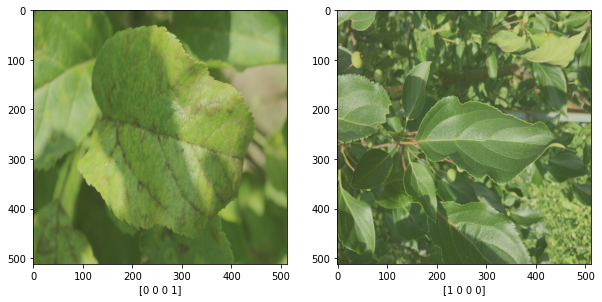

In [5]:
train_iter = iter(train_ds)
train_image_batch, train_label_batch = next(train_iter)

plt.figure(figsize=(10, 10))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(train_image_batch[i])
    plt.xlabel(str(train_label_batch[i].numpy()))
plt.show()

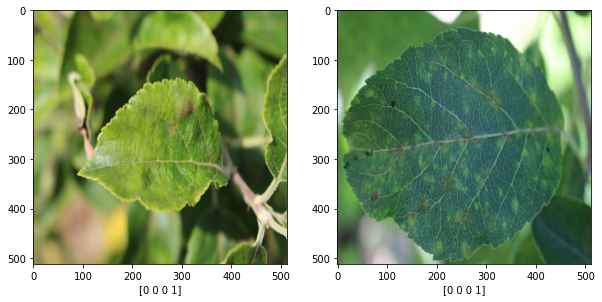

In [6]:
valid_iter = iter(valid_ds)
valid_image_batch, valid_label_batch = next(valid_iter)

plt.figure(figsize=(10, 10))
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(valid_image_batch[i])
    plt.xlabel(str(valid_label_batch[i].numpy()))
plt.show()

In [13]:
def build_model():
    model = keras.Sequential([
        efn.EfficientNetB6(input_shape=[INPUT_SIZE[1], INPUT_SIZE[0], 3],
                           weights='imagenet',
                           include_top=False),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(4, activation='softmax')
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])
    return model


keras.backend.clear_session()
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Model)      (None, 16, 16, 2304)      40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 9220      
Total params: 40,969,356
Trainable params: 40,744,924
Non-trainable params: 224,432
_________________________________________________________________


In [8]:
def schedule(epoch, current_lr):
    if epoch == 20:
        return 1e-4
    elif epoch == 40:
        return 2.5e-5
    elif epoch == 60:
        return 3.5e-6
    return current_lr


lr_scheduler = keras.callbacks.LearningRateScheduler(schedule, verbose=True)
tensorboard_callback = keras.callbacks.TensorBoard()

In [14]:
history = model.fit(train_ds,
                    epochs=60,
                    validation_data=valid_ds,
                    callbacks=[lr_scheduler, tensorboard_callback])

Train for 774 steps, validate for 137 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/80
774/774 [==============================] - 267s 345ms/step - loss: 1.0546 - categorical_accuracy: 0.5792 - val_loss: 0.4196 - val_categorical_accuracy: 0.9051

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/80
774/774 [==============================] - 242s 312ms/step - loss: 0.6072 - categorical_accuracy: 0.7867 - val_loss: 0.8308 - val_categorical_accuracy: 0.7810

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/80
774/774 [==============================] - 245s 316ms/step - loss: 0.4892 - categorical_accuracy: 0.8474 - val_loss: 0.4996 - val_categorical_accuracy: 0.8175

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 4/80
774/774 [==============================] - 239s 309ms/step - loss: 0.3908 - categorical_accurac


Epoch 00033: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 33/80
774/774 [==============================] - 236s 305ms/step - loss: 0.0384 - categorical_accuracy: 0.9858 - val_loss: 0.2149 - val_categorical_accuracy: 0.9453

Epoch 00034: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 34/80
774/774 [==============================] - 239s 308ms/step - loss: 0.0437 - categorical_accuracy: 0.9877 - val_loss: 0.2139 - val_categorical_accuracy: 0.9489

Epoch 00035: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 35/80
774/774 [==============================] - 239s 309ms/step - loss: 0.0339 - categorical_accuracy: 0.9884 - val_loss: 0.1900 - val_categorical_accuracy: 0.9489

Epoch 00036: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 36/80
774/774 [==============================] - 239s 309ms/step - loss: 0.0429 - categorical_accuracy: 0.9864 - val_loss: 0.1643 - val_categ

774/774 [==============================] - 235s 304ms/step - loss: 0.0154 - categorical_accuracy: 0.9968 - val_loss: 0.2002 - val_categorical_accuracy: 0.9489

Epoch 00066: LearningRateScheduler reducing learning rate to 3.5000000480067683e-06.
Epoch 66/80
774/774 [==============================] - 238s 307ms/step - loss: 0.0136 - categorical_accuracy: 0.9961 - val_loss: 0.2004 - val_categorical_accuracy: 0.9526

Epoch 00067: LearningRateScheduler reducing learning rate to 3.5000000480067683e-06.
Epoch 67/80
774/774 [==============================] - 238s 308ms/step - loss: 0.0096 - categorical_accuracy: 0.9987 - val_loss: 0.1989 - val_categorical_accuracy: 0.9526

Epoch 00068: LearningRateScheduler reducing learning rate to 3.5000000480067683e-06.
Epoch 68/80
774/774 [==============================] - 238s 307ms/step - loss: 0.0149 - categorical_accuracy: 0.9942 - val_loss: 0.1890 - val_categorical_accuracy: 0.9489

Epoch 00069: LearningRateScheduler reducing learning rate to 3.500000

In [15]:
checkpoint = tf.train.Checkpoint()
checkpoint.save('../../checkpoint/plant-pathology/efficientnet-b6.checkpoint')

'../../checkpoint/plant-pathology/noisy-student.checkpoint-1'

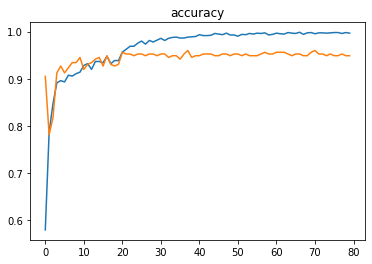

In [16]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('accuracy')
plt.show()

In [17]:
submission('efficientnet-b6.csv')

processed: 1821/1821
  image_id       healthy  multiple_diseases          rust          scab
0   Test_0  1.172743e-06           0.000324  9.996747e-01  5.682582e-09
1   Test_1  3.732744e-08           0.000073  9.999270e-01  1.701346e-10
2   Test_2  2.297795e-07           0.000043  2.753042e-13  9.999566e-01
3   Test_3  9.999653e-01           0.000018  6.053899e-06  1.053362e-05
4   Test_4  1.374299e-10           0.000027  9.999732e-01  1.907533e-12


In [18]:
!kaggle competitions submit -c plant-pathology-2020-fgvc7 -f efficientnet-b6.csv -m "noisy student submission"

100%|████████████████████████████████████████| 168k/168k [00:08<00:00, 20.6kB/s]
Successfully submitted to Plant Pathology 2020 - FGVC7

# EfficientNet-B6  Noisy Student

In [7]:
def build_model():
    model = keras.Sequential([
        efn.EfficientNetB6(input_shape=[INPUT_SIZE[1], INPUT_SIZE[0], 3],
                           weights='noisy-student',
                           include_top=False),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(4, activation='softmax')
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])
    return model


keras.backend.clear_session()
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Model)      (None, 16, 16, 2304)      40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 9220      
Total params: 40,969,356
Trainable params: 40,744,924
Non-trainable params: 224,432
_________________________________________________________________


In [12]:
BATCH_SIZE = 2
train_ds, valid_ds = get_train_valid_split('./train.csv')

train_ds = train_ds.map(train_pipeline)
valid_ds = valid_ds.map(valid_pipeline)
train_ds = train_ds.shuffle(100).batch(BATCH_SIZE)
valid_ds = valid_ds.shuffle(100).batch(BATCH_SIZE)

print(train_ds)
print(valid_ds)

train size:  1547
valid size:  274
<BatchDataset shapes: ((None, 512, 512, None), (None, 4)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((None, 512, 512, None), (None, 4)), types: (tf.float32, tf.int32)>


In [13]:
def schedule(epoch, current_lr):
    if epoch == 20:
        return 1e-4
    elif epoch == 40:
        return 2.5e-5
    elif epoch == 60:
        return 3.5e-6
    return current_lr


lr_scheduler = keras.callbacks.LearningRateScheduler(schedule, verbose=True)
tensorboard_callback = keras.callbacks.TensorBoard()

history = model.fit(train_ds,
                    epochs=60,
                    validation_data=valid_ds,
                    callbacks=[lr_scheduler, tensorboard_callback])

Train for 774 steps, validate for 137 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/60
774/774 [==============================] - 236s 305ms/step - loss: 1.2779 - categorical_accuracy: 0.4421 - val_loss: 0.6692 - val_categorical_accuracy: 0.7847

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/60
774/774 [==============================] - 236s 306ms/step - loss: 0.9872 - categorical_accuracy: 0.6031 - val_loss: 0.4026 - val_categorical_accuracy: 0.8832

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/60
774/774 [==============================] - 239s 308ms/step - loss: 0.6207 - categorical_accuracy: 0.8035 - val_loss: 0.3569 - val_categorical_accuracy: 0.8978

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 4/60
774/774 [==============================] - 240s 310ms/step - loss: 0.4853 - categorical_accurac


Epoch 00033: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 33/60
774/774 [==============================] - 230s 297ms/step - loss: 0.0712 - categorical_accuracy: 0.9754 - val_loss: 0.1505 - val_categorical_accuracy: 0.9562

Epoch 00034: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 34/60
774/774 [==============================] - 230s 298ms/step - loss: 0.0660 - categorical_accuracy: 0.9813 - val_loss: 0.1537 - val_categorical_accuracy: 0.9562

Epoch 00035: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 35/60
774/774 [==============================] - 234s 302ms/step - loss: 0.0598 - categorical_accuracy: 0.9793 - val_loss: 0.1557 - val_categorical_accuracy: 0.9635

Epoch 00036: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
Epoch 36/60
774/774 [==============================] - 231s 298ms/step - loss: 0.0560 - categorical_accuracy: 0.9813 - val_loss: 0.1526 - val_categ

In [14]:
checkpoint = tf.train.Checkpoint()
checkpoint.save('../../checkpoint/plant-pathology/noisy-student.checkpoint')

'../../checkpoint/plant-pathology/noisy-student.checkpoint-1'

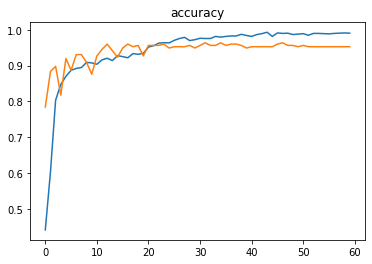

In [15]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('accuracy')
plt.show()

In [17]:
def submission(output_name):
    csv = pd.read_csv('./sample_submission.csv')
    for i in range(len(csv)):
        row = csv.iloc[i]
        image = read_image('./images/' + row[0] + '.jpg')
        image = tf.image.resize(image, INPUT_SIZE)
        image = image[tf.newaxis, ...]
        results = model.predict(image)
        csv.iloc[i, 1:] = results[0]
        print('\rprocessed: %d/%d' % (i+1, len(csv)), end='')
    print()
    csv.to_csv(output_name, index=False)
    print(csv.head())

submission('noisy-student.csv')

processed: 1821/1821
  image_id       healthy  multiple_diseases          rust          scab
0   Test_0  7.969221e-10           0.001106  9.988942e-01  1.147888e-11
1   Test_1  5.265469e-10           0.000444  9.995561e-01  2.136577e-12
2   Test_2  1.970137e-06           0.000381  1.053537e-11  9.996166e-01
3   Test_3  9.999653e-01           0.000030  5.582937e-07  4.555029e-06
4   Test_4  3.646012e-11           0.000897  9.991034e-01  1.032839e-12


In [18]:
!kaggle competitions submit -c plant-pathology-2020-fgvc7 -f noisy-student.csv -m "noisy student submission"

100%|████████████████████████████████████████| 168k/168k [00:08<00:00, 20.8kB/s]
Successfully submitted to Plant Pathology 2020 - FGVC7

# EfficientNet-B7

EfficientNet B7 seems a little overfitting

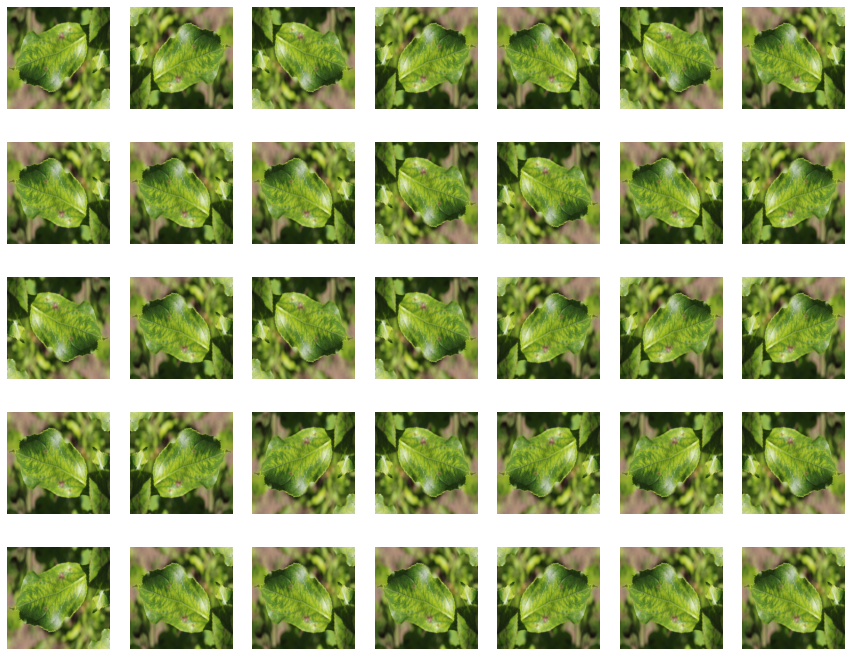

In [10]:
INPUT_SIZE = (600, 600)
SCALE_UP = 1.3


@tf.function
def random_process(image):
    image = random_flip(image)
    image = tf.image.resize(image, [INPUT_SIZE[0], INPUT_SIZE[0]])
    # image = random_jitter(image)
    return image


plt.figure(figsize=(15, 12))
for n in range(35):
    test_image = random_process(train_image)
    plt.subplot(5, 7, n+1)
    plt.imshow(test_image)
    plt.axis('off')

plt.show()

In [11]:
BATCH_SIZE = 1
train_ds, valid_ds = get_train_valid_split('./train.csv')

train_ds = train_ds.map(train_pipeline)
valid_ds = valid_ds.map(valid_pipeline)
train_ds = train_ds.shuffle(100).batch(BATCH_SIZE)
valid_ds = valid_ds.shuffle(100).batch(BATCH_SIZE)

print(train_ds)
print(valid_ds)

train size:  1547
valid size:  274
<BatchDataset shapes: ((None, 600, 600, None), (None, 4)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((None, 600, 600, None), (None, 4)), types: (tf.float32, tf.int32)>


In [12]:
def build_model():
    model = keras.Sequential([
        efn.EfficientNetB7(input_shape=[INPUT_SIZE[1], INPUT_SIZE[0], 3],
                           weights='noisy-student',
                           include_top=False),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(4, activation='softmax')
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(1.5e-5, beta_1=0.5),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])
    return model


keras.backend.clear_session()
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Model)      (None, 19, 19, 2560)      64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 10244     
Total params: 64,107,924
Trainable params: 63,797,204
Non-trainable params: 310,720
_________________________________________________________________


In [13]:
def schedule(epoch, current_lr):
    if epoch == 10:
        return 5e-6
    return current_lr


lr_scheduler = keras.callbacks.LearningRateScheduler(schedule, verbose=True)
tensorboard_callback = keras.callbacks.TensorBoard()

history = model.fit(train_ds,
                    epochs=20,
                    validation_data=valid_ds,
                    callbacks=[lr_scheduler, tensorboard_callback])

Train for 1547 steps, validate for 274 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 2.499999936844688e-05.
Epoch 1/20
1547/1547 [==============================] - 595s 385ms/step - loss: 1.2563 - categorical_accuracy: 0.3394 - val_loss: 1.5088 - val_categorical_accuracy: 0.2226

Epoch 00002: LearningRateScheduler reducing learning rate to 2.499999936844688e-05.
Epoch 2/20
1547/1547 [==============================] - 571s 369ms/step - loss: 0.9786 - categorical_accuracy: 0.5546 - val_loss: 1.0945 - val_categorical_accuracy: 0.4745

Epoch 00003: LearningRateScheduler reducing learning rate to 2.499999936844688e-05.
Epoch 3/20
1547/1547 [==============================] - 571s 369ms/step - loss: 0.6724 - categorical_accuracy: 0.6490 - val_loss: 1.5289 - val_categorical_accuracy: 0.4124

Epoch 00004: LearningRateScheduler reducing learning rate to 2.499999936844688e-05.
Epoch 4/20
1547/1547 [==============================] - 571s 369ms/step - loss: 0.6032 - categorica

In [14]:
checkpoint = tf.train.Checkpoint()
checkpoint.save('../../checkpoint/plant-pathology/noisy-student-b7.checkpoint')

'../../checkpoint/plant-pathology/noisy-student-b7.checkpoint-1'

In [15]:
def submission(output_name):
    csv = pd.read_csv('./sample_submission.csv')
    for i in range(len(csv)):
        row = csv.iloc[i]
        image = read_image('./images/' + row[0] + '.jpg')
        image = tf.image.resize(image, INPUT_SIZE)
        image = image[tf.newaxis, ...]
        results = model.predict(image)
        csv.iloc[i, 1:] = results[0]
        print('\rprocessed: %d/%d' % (i+1, len(csv)), end='')
    print()
    csv.to_csv(output_name, index=False)
    print(csv.head())


submission('noisy-student-b7.csv')

processed: 1821/1821
  image_id   healthy  multiple_diseases          rust          scab
0   Test_0  0.001332       2.462241e-01  5.847866e-03  7.465966e-01
1   Test_1  0.000218       2.869788e-01  3.688907e-03  7.091143e-01
2   Test_2  0.003493       1.789987e-03  2.378109e-08  9.947167e-01
3   Test_3  1.000000       2.066558e-09  7.096201e-09  9.068240e-12
4   Test_4  0.000055       1.550878e-01  2.790589e-03  8.420667e-01


In [16]:
!kaggle competitions submit -c plant-pathology-2020-fgvc7 -f noisy-student-b7.csv -m "noisy student b7 submission"

100%|████████████████████████████████████████| 164k/164k [00:06<00:00, 25.0kB/s]
Successfully submitted to Plant Pathology 2020 - FGVC7

# EfficientNet B4 Noisy Student

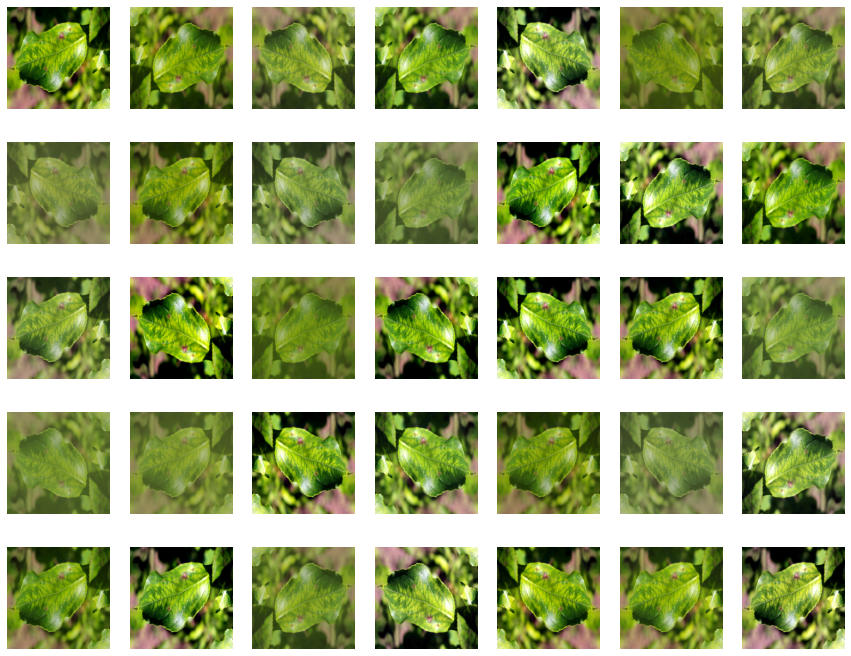

In [20]:
INPUT_SIZE = (380, 380)
SCALE_UP = 1.3


@tf.function
def random_process(image):
    image = random_flip(image)
    # if tf.random.uniform((), 0, 1.0) > 0.1:
    #     image = random_crop(image)
    image = tf.image.resize(image, [INPUT_SIZE[0], INPUT_SIZE[0]])
    image = random_jitter(image)
    return image


plt.figure(figsize=(15, 12))
for n in range(35):
    test_image = random_process(train_image)
    plt.subplot(5, 7, n+1)
    plt.imshow(test_image)
    plt.axis('off')

plt.show()

In [26]:
def build_model():
    model = keras.Sequential([
        efn.EfficientNetB4(input_shape=[INPUT_SIZE[1], INPUT_SIZE[0], 3],
                           weights='noisy-student',
                           include_top=False),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(4, activation='softmax')
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(2.5e-4),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])
    return model


keras.backend.clear_session()
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b4 (Model)      (None, 12, 12, 1792)      17673816  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 7172      
Total params: 17,680,988
Trainable params: 17,555,788
Non-trainable params: 125,200
_________________________________________________________________


In [27]:
BATCH_SIZE = 6
train_ds, valid_ds = get_train_valid_split('./train.csv')

train_ds = train_ds.map(train_pipeline)
valid_ds = valid_ds.map(valid_pipeline)
train_ds = train_ds.shuffle(100).batch(BATCH_SIZE)
valid_ds = valid_ds.shuffle(100).batch(BATCH_SIZE)

print(train_ds)
print(valid_ds)

train size:  1547
valid size:  274
<BatchDataset shapes: ((None, 380, 380, None), (None, 4)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((None, 380, 380, None), (None, 4)), types: (tf.float32, tf.int32)>


In [28]:
def schedule(epoch, current_lr):
    if epoch == 20:
        return 6e-5
    elif epoch == 40:
        return 1e-5
    return current_lr


lr_scheduler = keras.callbacks.LearningRateScheduler(schedule, verbose=True)
tensorboard_callback = keras.callbacks.TensorBoard()

history = model.fit(train_ds,
                    epochs=60,
                    validation_data=valid_ds,
                    callbacks=[lr_scheduler, tensorboard_callback])

Train for 258 steps, validate for 46 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0002500000118743628.
Epoch 1/60
258/258 [==============================] - 87s 338ms/step - loss: 0.5560 - categorical_accuracy: 0.8041 - val_loss: 0.3447 - val_categorical_accuracy: 0.9088

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0002500000118743628.
Epoch 2/60
258/258 [==============================] - 74s 286ms/step - loss: 0.3615 - categorical_accuracy: 0.8856 - val_loss: 0.2881 - val_categorical_accuracy: 0.9088

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0002500000118743628.
Epoch 3/60
258/258 [==============================] - 75s 290ms/step - loss: 0.2594 - categorical_accuracy: 0.9153 - val_loss: 0.3119 - val_categorical_accuracy: 0.9161

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0002500000118743628.
Epoch 4/60
258/258 [==============================] - 74s 287ms/step - loss: 0.1990 - categorical_accuracy: 0.

258/258 [==============================] - 72s 280ms/step - loss: 0.0036 - categorical_accuracy: 0.9994 - val_loss: 0.2749 - val_categorical_accuracy: 0.9562

Epoch 00034: LearningRateScheduler reducing learning rate to 5.999999848427251e-05.
Epoch 34/60
258/258 [==============================] - 72s 280ms/step - loss: 0.0062 - categorical_accuracy: 0.9981 - val_loss: 0.2988 - val_categorical_accuracy: 0.9562

Epoch 00035: LearningRateScheduler reducing learning rate to 5.999999848427251e-05.
Epoch 35/60
258/258 [==============================] - 72s 280ms/step - loss: 0.0036 - categorical_accuracy: 0.9981 - val_loss: 0.3416 - val_categorical_accuracy: 0.9489

Epoch 00036: LearningRateScheduler reducing learning rate to 5.999999848427251e-05.
Epoch 36/60
258/258 [==============================] - 72s 280ms/step - loss: 0.0072 - categorical_accuracy: 0.9968 - val_loss: 0.3115 - val_categorical_accuracy: 0.9489

Epoch 00037: LearningRateScheduler reducing learning rate to 5.9999998484272

In [29]:
checkpoint = tf.train.Checkpoint()
checkpoint.save('../../checkpoint/plant-pathology/noisy-student-b4.checkpoint')

'../../checkpoint/plant-pathology/noisy-student-b4.checkpoint-1'

In [30]:
submission('noisy-student-b4.csv')

processed: 1821/1821
  image_id       healthy  multiple_diseases          rust          scab
0   Test_0  3.233785e-07       2.483622e-03  9.975123e-01  3.667643e-06
1   Test_1  1.527226e-07       4.265874e-05  9.999566e-01  5.449131e-07
2   Test_2  3.878294e-09       1.356328e-07  4.364092e-10  9.999999e-01
3   Test_3  9.999999e-01       6.474278e-09  6.038804e-08  7.776966e-08
4   Test_4  1.326291e-07       2.368715e-04  9.997630e-01  2.339114e-09


In [33]:
!kaggle competitions submit -c plant-pathology-2020-fgvc7 -f noisy-student-b4.csv -m "noisy student b4 submission"

100%|████████████████████████████████████████| 168k/168k [00:08<00:00, 20.6kB/s]
Successfully submitted to Plant Pathology 2020 - FGVC7

# EfficientNet B3 Noisy Student

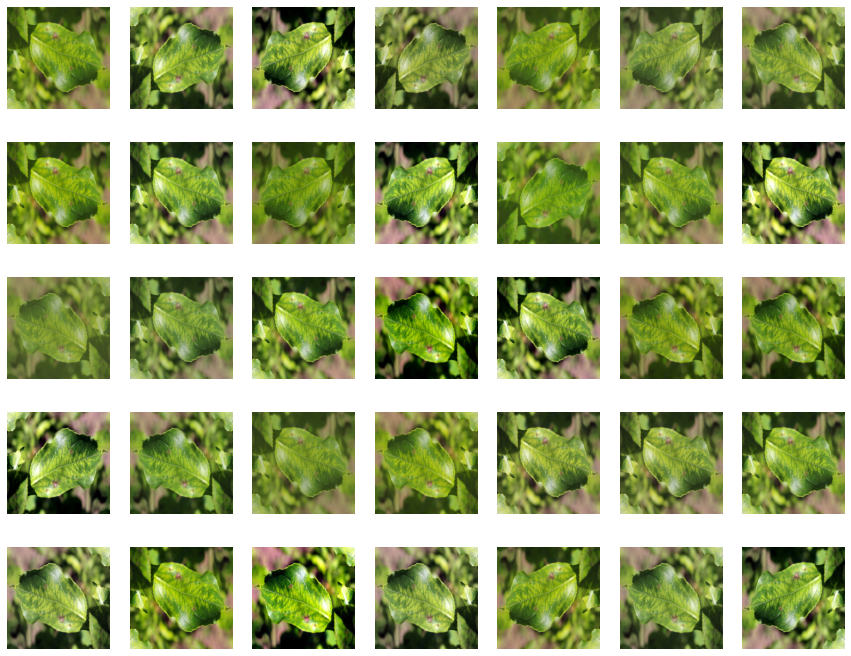

In [31]:
INPUT_SIZE = (300, 300)
SCALE_UP = 1.3


@tf.function
def random_process(image):
    image = random_flip(image)
    # if tf.random.uniform((), 0, 1.0) > 0.1:
    #     image = random_crop(image)
    image = tf.image.resize(image, [INPUT_SIZE[0], INPUT_SIZE[0]])
    image = random_jitter(image)
    return image


plt.figure(figsize=(15, 12))
for n in range(35):
    test_image = random_process(train_image)
    plt.subplot(5, 7, n+1)
    plt.imshow(test_image)
    plt.axis('off')

plt.show()

In [32]:
def build_model():
    model = keras.Sequential([
        efn.EfficientNetB3(input_shape=[INPUT_SIZE[1], INPUT_SIZE[0], 3],
                           weights='noisy-student',
                           include_top=False),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(4, activation='softmax')
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(2.5e-4),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])
    return model


keras.backend.clear_session()
model = build_model()
model.summary()

43933696/43933088 [==============================] - 7s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Model)      (None, 10, 10, 1536)      10783528  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 6148      
Total params: 10,789,676
Trainable params: 10,702,380
Non-trainable params: 87,296
_________________________________________________________________


In [34]:
BATCH_SIZE = 8
train_ds, valid_ds = get_train_valid_split('./train.csv')

train_ds = train_ds.map(train_pipeline)
valid_ds = valid_ds.map(valid_pipeline)
train_ds = train_ds.shuffle(100).batch(BATCH_SIZE)
valid_ds = valid_ds.shuffle(100).batch(BATCH_SIZE)

print(train_ds)
print(valid_ds)

train size:  1547
valid size:  274
<BatchDataset shapes: ((None, 300, 300, None), (None, 4)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((None, 300, 300, None), (None, 4)), types: (tf.float32, tf.int32)>


In [35]:
def schedule(epoch, current_lr):
    if epoch == 20:
        return 6e-5
    elif epoch == 40:
        return 1e-5
    return current_lr


lr_scheduler = keras.callbacks.LearningRateScheduler(schedule, verbose=True)
tensorboard_callback = keras.callbacks.TensorBoard()

history = model.fit(train_ds,
                    epochs=60,
                    validation_data=valid_ds,
                    callbacks=[lr_scheduler, tensorboard_callback])

Train for 194 steps, validate for 35 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0002500000118743628.
Epoch 1/60
194/194 [==============================] - 50s 259ms/step - loss: 0.5364 - categorical_accuracy: 0.8125 - val_loss: 0.2205 - val_categorical_accuracy: 0.9197

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0002500000118743628.
Epoch 2/60
194/194 [==============================] - 38s 196ms/step - loss: 0.3504 - categorical_accuracy: 0.8895 - val_loss: 0.2275 - val_categorical_accuracy: 0.9416

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0002500000118743628.
Epoch 3/60
194/194 [==============================] - 38s 197ms/step - loss: 0.2458 - categorical_accuracy: 0.9231 - val_loss: 0.1953 - val_categorical_accuracy: 0.9416

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0002500000118743628.
Epoch 4/60
194/194 [==============================] - 38s 196ms/step - loss: 0.1772 - categorical_accuracy: 0.

194/194 [==============================] - 38s 196ms/step - loss: 0.0036 - categorical_accuracy: 0.9987 - val_loss: 0.1967 - val_categorical_accuracy: 0.9599

Epoch 00034: LearningRateScheduler reducing learning rate to 5.999999848427251e-05.
Epoch 34/60
194/194 [==============================] - 38s 197ms/step - loss: 0.0050 - categorical_accuracy: 0.9994 - val_loss: 0.1904 - val_categorical_accuracy: 0.9453

Epoch 00035: LearningRateScheduler reducing learning rate to 5.999999848427251e-05.
Epoch 35/60
194/194 [==============================] - 38s 197ms/step - loss: 0.0032 - categorical_accuracy: 0.9994 - val_loss: 0.1993 - val_categorical_accuracy: 0.9489

Epoch 00036: LearningRateScheduler reducing learning rate to 5.999999848427251e-05.
Epoch 36/60
194/194 [==============================] - 38s 197ms/step - loss: 0.0044 - categorical_accuracy: 0.9994 - val_loss: 0.2218 - val_categorical_accuracy: 0.9489

Epoch 00037: LearningRateScheduler reducing learning rate to 5.9999998484272

In [36]:
checkpoint = tf.train.Checkpoint()
checkpoint.save('../../checkpoint/plant-pathology/noisy-student-b3.checkpoint')

'../../checkpoint/plant-pathology/noisy-student-b3.checkpoint-1'

In [37]:
submission('noisy-student-b3.csv')

processed: 1821/1821
  image_id       healthy  multiple_diseases          rust          scab
0   Test_0  9.028672e-08       4.533626e-05  9.999546e-01  3.286173e-09
1   Test_1  8.232346e-12       2.733954e-07  9.999992e-01  5.902409e-07
2   Test_2  5.477265e-10       5.212073e-08  1.262661e-07  9.999999e-01
3   Test_3  9.999895e-01       1.049959e-07  7.453366e-06  2.923145e-06
4   Test_4  3.852938e-05       1.156408e-03  9.987675e-01  3.758330e-05


In [38]:
!kaggle competitions submit -c plant-pathology-2020-fgvc7 -f noisy-student-b3.csv -m "noisy student b3 submission"

100%|████████████████████████████████████████| 168k/168k [00:05<00:00, 33.2kB/s]
Successfully submitted to Plant Pathology 2020 - FGVC7

# EfficientNet B0 Noisy Student

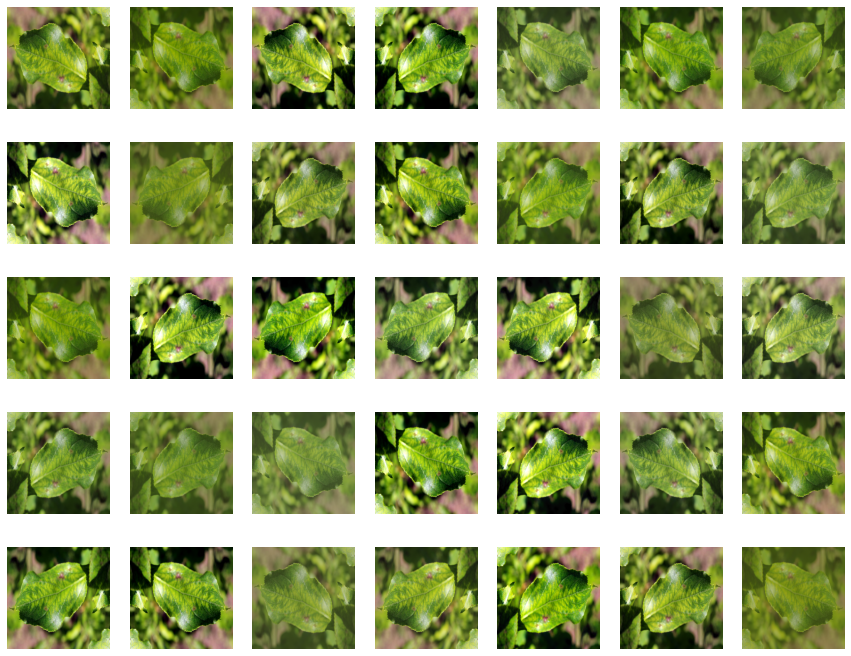

In [8]:
INPUT_SIZE = (224, 224)
SCALE_UP = 1.3


@tf.function
def random_process(image):
    image = random_flip(image)
    # if tf.random.uniform((), 0, 1.0) > 0.1:
    #     image = random_crop(image)
    image = tf.image.resize(image, [INPUT_SIZE[0], INPUT_SIZE[0]])
    image = random_jitter(image)
    return image


show_random_processed(random_process)

In [9]:
def build_model():
    model = keras.Sequential([
        efn.EfficientNetB0(input_shape=[INPUT_SIZE[1], INPUT_SIZE[0], 3],
                           weights='noisy-student',
                           include_top=False),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(4, activation='softmax')
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(2.5e-4),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])
    return model


keras.backend.clear_session()
model = build_model()
model.summary()

16703488/16696600 [==============================] - 8s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 5124      
Total params: 4,054,688
Trainable params: 4,012,672
Non-trainable params: 42,016
_________________________________________________________________


In [10]:
BATCH_SIZE = 16
train_ds, valid_ds = get_train_valid_split('./train.csv')

train_ds = train_ds.map(train_pipeline)
valid_ds = valid_ds.map(valid_pipeline)
train_ds = train_ds.shuffle(100).batch(BATCH_SIZE)
valid_ds = valid_ds.shuffle(100).batch(BATCH_SIZE)

print(train_ds)
print(valid_ds)

train size:  1547
valid size:  274
<BatchDataset shapes: ((None, 224, 224, None), (None, 4)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((None, 224, 224, None), (None, 4)), types: (tf.float32, tf.int32)>


In [11]:
def schedule(epoch, current_lr):
    if epoch == 20:
        return 6e-5
    elif epoch == 40:
        return 1e-5
    return current_lr


lr_scheduler = keras.callbacks.LearningRateScheduler(schedule, verbose=True)
tensorboard_callback = keras.callbacks.TensorBoard()

history = model.fit(train_ds,
                    epochs=60,
                    validation_data=valid_ds,
                    callbacks=[lr_scheduler, tensorboard_callback])

Train for 97 steps, validate for 18 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0002500000118743628.
Epoch 1/60
97/97 [==============================] - 61s 633ms/step - loss: 0.6185 - categorical_accuracy: 0.7841 - val_loss: 0.3510 - val_categorical_accuracy: 0.8942

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0002500000118743628.
Epoch 2/60
97/97 [==============================] - 31s 323ms/step - loss: 0.2916 - categorical_accuracy: 0.9024 - val_loss: 0.3202 - val_categorical_accuracy: 0.9161

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0002500000118743628.
Epoch 3/60
97/97 [==============================] - 31s 323ms/step - loss: 0.1938 - categorical_accuracy: 0.9308 - val_loss: 0.1826 - val_categorical_accuracy: 0.9343

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0002500000118743628.
Epoch 4/60
97/97 [==============================] - 32s 325ms/step - loss: 0.1891 - categorical_accuracy: 0.9341 - va

97/97 [==============================] - 31s 317ms/step - loss: 0.0073 - categorical_accuracy: 0.9968 - val_loss: 0.2066 - val_categorical_accuracy: 0.9562

Epoch 00034: LearningRateScheduler reducing learning rate to 5.999999848427251e-05.
Epoch 34/60
97/97 [==============================] - 30s 312ms/step - loss: 0.0075 - categorical_accuracy: 0.9974 - val_loss: 0.2002 - val_categorical_accuracy: 0.9562

Epoch 00035: LearningRateScheduler reducing learning rate to 5.999999848427251e-05.
Epoch 35/60
97/97 [==============================] - 30s 309ms/step - loss: 0.0090 - categorical_accuracy: 0.9961 - val_loss: 0.2131 - val_categorical_accuracy: 0.9635

Epoch 00036: LearningRateScheduler reducing learning rate to 5.999999848427251e-05.
Epoch 36/60
97/97 [==============================] - 30s 312ms/step - loss: 0.0098 - categorical_accuracy: 0.9961 - val_loss: 0.2025 - val_categorical_accuracy: 0.9562

Epoch 00037: LearningRateScheduler reducing learning rate to 5.999999848427251e-05.


In [14]:
checkpoint = tf.train.Checkpoint()
checkpoint.save('../../checkpoint/plant-pathology/noisy-student-b0.checkpoint')

'../../checkpoint/plant-pathology/noisy-student-b0.checkpoint-1'

In [16]:
submission('noisy-student-b0.csv')

processed: 1821/1821
  image_id       healthy  multiple_diseases          rust          scab
0   Test_0  1.825972e-06       1.970987e-04  9.997939e-01  7.180894e-06
1   Test_1  2.788777e-07       7.164234e-07  9.999989e-01  1.723180e-07
2   Test_2  3.115087e-15       1.331646e-13  1.760170e-15  1.000000e+00
3   Test_3  1.000000e+00       2.468078e-09  1.418559e-08  1.156881e-10
4   Test_4  1.321528e-13       2.027679e-12  1.000000e+00  4.704733e-22


In [17]:
!kaggle competitions submit -c plant-pathology-2020-fgvc7 -f noisy-student-b0.csv -m "noisy student b0 submission"

100%|████████████████████████████████████████| 165k/165k [00:06<00:00, 27.6kB/s]
Successfully submitted to Plant Pathology 2020 - FGVC7

# EfficientNet B2 Noisy Student

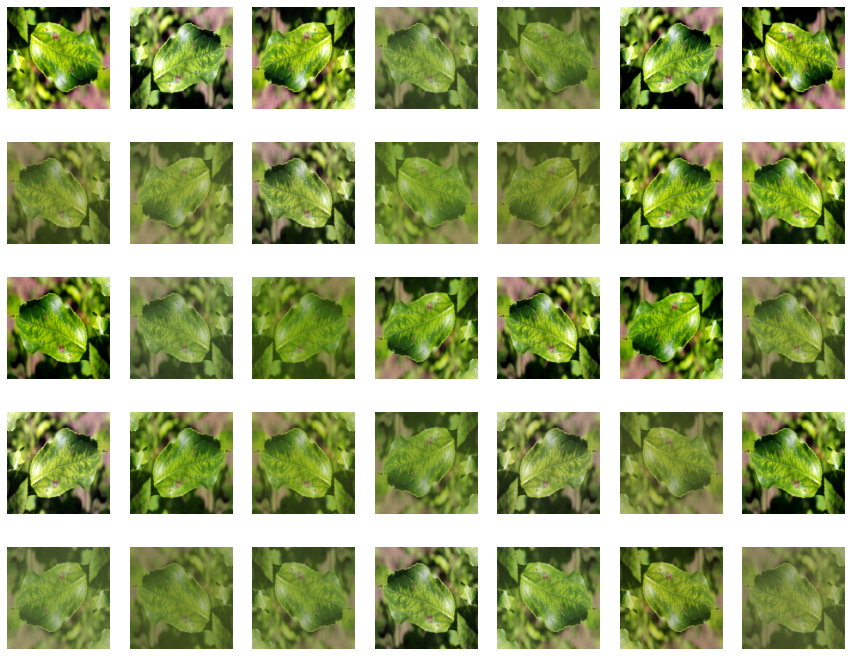

In [20]:
INPUT_SIZE = (260, 260)
SCALE_UP = 1.3


@tf.function
def random_process(image):
    image = random_flip(image)
    # if tf.random.uniform((), 0, 1.0) > 0.1:
    #     image = random_crop(image)
    image = tf.image.resize(image, [INPUT_SIZE[0], INPUT_SIZE[0]])
    image = random_jitter(image)
    return image


show_random_processed(random_process)

In [21]:
def build_model():
    model = keras.Sequential([
        efn.EfficientNetB2(input_shape=[INPUT_SIZE[1], INPUT_SIZE[0], 3],
                           weights='noisy-student',
                           include_top=False),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(4, activation='softmax')
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(2.5e-4),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])
    return model


keras.backend.clear_session()
model = build_model()
model.summary()

31784960/31782304 [==============================] - 6s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b2 (Model)      (None, 9, 9, 1408)        7768562   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 5636      
Total params: 7,774,198
Trainable params: 7,706,630
Non-trainable params: 67,568
_________________________________________________________________


In [22]:
BATCH_SIZE = 12
train_ds, valid_ds = get_train_valid_split('./train.csv')

train_ds = train_ds.map(train_pipeline)
valid_ds = valid_ds.map(valid_pipeline)
train_ds = train_ds.shuffle(100).batch(BATCH_SIZE)
valid_ds = valid_ds.shuffle(100).batch(BATCH_SIZE)

print(train_ds)
print(valid_ds)

train size:  1547
valid size:  274
<BatchDataset shapes: ((None, 260, 260, None), (None, 4)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((None, 260, 260, None), (None, 4)), types: (tf.float32, tf.int32)>


In [23]:
def schedule(epoch, current_lr):
    if epoch == 20:
        return 6e-5
    elif epoch == 40:
        return 1e-5
    return current_lr


lr_scheduler = keras.callbacks.LearningRateScheduler(schedule, verbose=True)
tensorboard_callback = keras.callbacks.TensorBoard()

history = model.fit(train_ds,
                    epochs=60,
                    validation_data=valid_ds,
                    callbacks=[lr_scheduler, tensorboard_callback])

Train for 129 steps, validate for 23 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0002500000118743628.
Epoch 1/60
129/129 [==============================] - 42s 327ms/step - loss: 0.5707 - categorical_accuracy: 0.8022 - val_loss: 0.5920 - val_categorical_accuracy: 0.8139

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0002500000118743628.
Epoch 2/60
129/129 [==============================] - 31s 242ms/step - loss: 0.2497 - categorical_accuracy: 0.9121 - val_loss: 0.1833 - val_categorical_accuracy: 0.9307

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0002500000118743628.
Epoch 3/60
129/129 [==============================] - 31s 242ms/step - loss: 0.2013 - categorical_accuracy: 0.9367 - val_loss: 0.1706 - val_categorical_accuracy: 0.9416

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0002500000118743628.
Epoch 4/60
129/129 [==============================] - 31s 242ms/step - loss: 0.1335 - categorical_accuracy: 0.

129/129 [==============================] - 33s 255ms/step - loss: 0.0029 - categorical_accuracy: 0.9994 - val_loss: 0.0372 - val_categorical_accuracy: 0.9891

Epoch 00034: LearningRateScheduler reducing learning rate to 5.999999848427251e-05.
Epoch 34/60
129/129 [==============================] - 33s 253ms/step - loss: 0.0074 - categorical_accuracy: 0.9974 - val_loss: 0.0423 - val_categorical_accuracy: 0.9854

Epoch 00035: LearningRateScheduler reducing learning rate to 5.999999848427251e-05.
Epoch 35/60
129/129 [==============================] - 32s 250ms/step - loss: 0.0094 - categorical_accuracy: 0.9968 - val_loss: 0.0434 - val_categorical_accuracy: 0.9891

Epoch 00036: LearningRateScheduler reducing learning rate to 5.999999848427251e-05.
Epoch 36/60
129/129 [==============================] - 33s 252ms/step - loss: 0.0037 - categorical_accuracy: 0.9987 - val_loss: 0.0350 - val_categorical_accuracy: 0.9854

Epoch 00037: LearningRateScheduler reducing learning rate to 5.9999998484272

In [24]:
checkpoint = tf.train.Checkpoint()
checkpoint.save('../../checkpoint/plant-pathology/noisy-student-b2.checkpoint')

'../../checkpoint/plant-pathology/noisy-student-b2.checkpoint-1'

In [25]:
submission('noisy-student-b2.csv')

processed: 1821/1821
  image_id       healthy  multiple_diseases          rust          scab
0   Test_0  4.917160e-06       1.869852e-03  9.980914e-01  3.376288e-05
1   Test_1  3.879272e-08       8.830340e-08  9.999998e-01  1.451773e-07
2   Test_2  9.584777e-14       2.810169e-12  2.059546e-13  1.000000e+00
3   Test_3  9.999986e-01       2.361302e-08  2.158303e-07  1.191021e-06
4   Test_4  3.647076e-08       2.847594e-07  9.999996e-01  5.289999e-09


In [26]:
!kaggle competitions submit -c plant-pathology-2020-fgvc7 -f noisy-student-b2.csv -m "noisy student b2 submission"

100%|████████████████████████████████████████| 165k/165k [00:08<00:00, 18.8kB/s]
Successfully submitted to Plant Pathology 2020 - FGVC7

# EfficientNet B1 Noisy Student

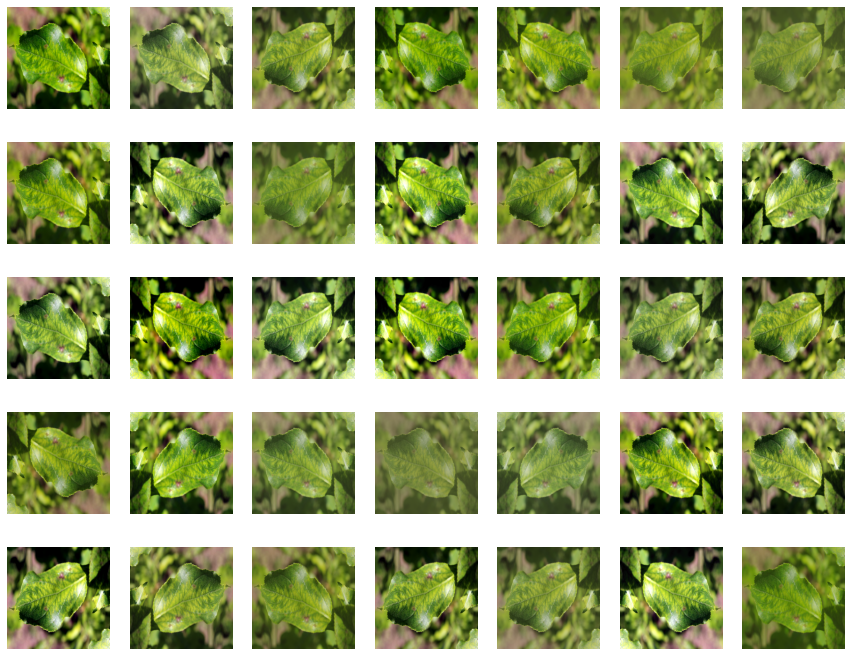

In [27]:
INPUT_SIZE = (240, 240)
SCALE_UP = 1.3


@tf.function
def random_process(image):
    image = random_flip(image)
    # if tf.random.uniform((), 0, 1.0) > 0.1:
    #     image = random_crop(image)
    image = tf.image.resize(image, [INPUT_SIZE[0], INPUT_SIZE[0]])
    image = random_jitter(image)
    return image


show_random_processed(random_process)

In [28]:
def build_model():
    model = keras.Sequential([
        efn.EfficientNetB1(input_shape=[INPUT_SIZE[1], INPUT_SIZE[0], 3],
                           weights='noisy-student',
                           include_top=False),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(4, activation='softmax')
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(2.5e-4),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])
    return model


keras.backend.clear_session()
model = build_model()
model.summary()

27017216/27010080 [==============================] - 6s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b1 (Model)      (None, 8, 8, 1280)        6575232   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 5124      
Total params: 6,580,356
Trainable params: 6,518,308
Non-trainable params: 62,048
_________________________________________________________________


In [29]:
BATCH_SIZE = 12
train_ds, valid_ds = get_train_valid_split('./train.csv')

train_ds = train_ds.map(train_pipeline)
valid_ds = valid_ds.map(valid_pipeline)
train_ds = train_ds.shuffle(100).batch(BATCH_SIZE)
valid_ds = valid_ds.shuffle(100).batch(BATCH_SIZE)

print(train_ds)
print(valid_ds)

train size:  1547
valid size:  274
<BatchDataset shapes: ((None, 240, 240, None), (None, 4)), types: (tf.float32, tf.int32)>
<BatchDataset shapes: ((None, 240, 240, None), (None, 4)), types: (tf.float32, tf.int32)>


In [30]:
def schedule(epoch, current_lr):
    if epoch == 20:
        return 6e-5
    elif epoch == 40:
        return 1e-5
    return current_lr


lr_scheduler = keras.callbacks.LearningRateScheduler(schedule, verbose=True)
tensorboard_callback = keras.callbacks.TensorBoard()

history = model.fit(train_ds,
                    epochs=60,
                    validation_data=valid_ds,
                    callbacks=[lr_scheduler, tensorboard_callback])

Train for 129 steps, validate for 23 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0002500000118743628.
Epoch 1/60
129/129 [==============================] - 42s 324ms/step - loss: 0.5513 - categorical_accuracy: 0.8112 - val_loss: 0.4182 - val_categorical_accuracy: 0.8686

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0002500000118743628.
Epoch 2/60
129/129 [==============================] - 32s 250ms/step - loss: 0.2802 - categorical_accuracy: 0.9166 - val_loss: 0.2988 - val_categorical_accuracy: 0.9124

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0002500000118743628.
Epoch 3/60
129/129 [==============================] - 32s 249ms/step - loss: 0.2028 - categorical_accuracy: 0.9289 - val_loss: 0.2741 - val_categorical_accuracy: 0.9234

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0002500000118743628.
Epoch 4/60
129/129 [==============================] - 32s 245ms/step - loss: 0.1470 - categorical_accuracy: 0.

129/129 [==============================] - 32s 246ms/step - loss: 0.0080 - categorical_accuracy: 0.9955 - val_loss: 0.3221 - val_categorical_accuracy: 0.9489

Epoch 00034: LearningRateScheduler reducing learning rate to 5.999999848427251e-05.
Epoch 34/60
129/129 [==============================] - 32s 246ms/step - loss: 0.0037 - categorical_accuracy: 0.9987 - val_loss: 0.3246 - val_categorical_accuracy: 0.9489

Epoch 00035: LearningRateScheduler reducing learning rate to 5.999999848427251e-05.
Epoch 35/60
129/129 [==============================] - 32s 245ms/step - loss: 0.0033 - categorical_accuracy: 0.9994 - val_loss: 0.3121 - val_categorical_accuracy: 0.9453

Epoch 00036: LearningRateScheduler reducing learning rate to 5.999999848427251e-05.
Epoch 36/60
129/129 [==============================] - 32s 249ms/step - loss: 0.0037 - categorical_accuracy: 0.9987 - val_loss: 0.3298 - val_categorical_accuracy: 0.9489

Epoch 00037: LearningRateScheduler reducing learning rate to 5.9999998484272

In [31]:
checkpoint = tf.train.Checkpoint()
checkpoint.save('../../checkpoint/plant-pathology/noisy-student-b1.checkpoint')

'../../checkpoint/plant-pathology/noisy-student-b1.checkpoint-1'

In [32]:
submission('noisy-student-b1.csv')

processed: 1821/1821
  image_id       healthy  multiple_diseases          rust          scab
0   Test_0  9.060357e-08       3.681017e-06  9.999961e-01  7.973654e-08
1   Test_1  3.556256e-09       3.676270e-08  9.999999e-01  6.763591e-08
2   Test_2  4.180624e-10       1.858383e-06  2.523358e-11  9.999981e-01
3   Test_3  1.000000e+00       1.110443e-08  3.366797e-09  2.307811e-08
4   Test_4  3.025729e-05       3.988438e-04  9.995707e-01  1.900505e-07


In [ ]:
!kaggle competitions submit -c plant-pathology-2020-fgvc7 -f noisy-student-b1.csv -m "noisy student b1 submission"